## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install pandas pillow

# # Install ONNX packages
# !pip install onnx onnxruntime onnx-simplifier

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_yolox_pytorch

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import json
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file
from cjm_pil_utils.core import resize_img

# Import YOLOX package
from cjm_yolox_pytorch.model import build_model
from cjm_yolox_pytorch.inference import YOLOXInferenceWrapper

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Import PIL for image manipulation
from PIL import Image, ImageDraw, ImageFont

# Import PyTorch dependencies
import torch

# Import ONNX dependencies
import onnx # Import the onnx module
from onnxsim import simplify # Import the method to simplify ONNX models
import onnxruntime as ort # Import the ONNX Runtime

## Setting Up the Project

### Set the Directory Paths

In [3]:
# The name for the project
project_name = f"pytorch-yolox-object-detector"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2023-08-17_16-14-43")

pd.Series({
    "Project Directory:": project_dir,
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-yolox-object-detector
Checkpoint Directory:,pytorch-yolox-object-detector/2023-08-17_16-14-43


### Download a Font File

In [4]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


## Loading the Checkpoint Data

### Load the Colormap

In [5]:
# The colormap path
colormap_path = list(checkpoint_dir.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
        colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

### Load the Normalization Statistics

In [6]:
# The normalization stats path
norm_stats_path = checkpoint_dir/'norm_stats.json'

# Read the normalization stats from the JSON file
with open(norm_stats_path, "r") as f:
    norm_stats_dict = json.load(f)

# Convert the dictionary to a tuple
norm_stats = (norm_stats_dict["mean"], norm_stats_dict["std_dev"])

# Print the mean and standard deviation
pd.DataFrame(norm_stats)

,0,1,2
0,0.5,0.5,0.5
1,1.0,1.0,1.0


### Load the Model Checkpoint

In [7]:
# The model checkpoint path
checkpoint_path = list(checkpoint_dir.glob('*.pth'))[0]

# Load the model checkpoint onto the CPU
model_checkpoint = torch.load(checkpoint_path, map_location='cpu')

### Load the Trained YOLOX Model

In [8]:
# Select the YOLOX model configuration
model_type = checkpoint_path.stem

# Create a YOLOX model with the number of output classes equal to the number of class names
model = build_model(model_type, len(class_names))

# Get stride values for processing output
strides = model.bbox_head.strides

# Initialize the model with the checkpoint parameters and buffers
model.load_state_dict(model_checkpoint)

The file ./pretrained_checkpoints/yolox_tiny.pth already exists and overwrite is set to False.


<All keys matched successfully>

## Exporting the Model to ONNX

### Prepare the Model for Inference

In [9]:
# Convert the normalization stats to tensors
mean_tensor = torch.tensor(norm_stats[0]).view(1, 3, 1, 1)
std_tensor = torch.tensor(norm_stats[1]).view(1, 3, 1, 1)

# Set the model to evaluation mode
model.eval();

# Wrap the model with preprocessing and post-processing steps
wrapped_model = YOLOXInferenceWrapper(model, 
                                      mean_tensor, 
                                      std_tensor, 
                                      scale_inp=False, # Scale input values from the rang [0,255] to [0,1]
                                      channels_last=False, # Have the model expect input in channels-last format
                                      run_box_and_prob_calculation=False # Enable or disable post-processing steps
                                     )

# Get the slice object for extracting the input dimensions
input_dim_slice = wrapped_model.input_dim_slice
input_dim_slice

slice(2, 4, None)

### Prepare the Input Tensor

In [10]:
input_tensor = torch.randn(1, 3, 256, 256)
# input_tensor = torch.randn(1, 256, 256, 3)

### Export the Model to ONNX

In [11]:
# Set a filename for the ONNX model
onnx_file_path = f"{checkpoint_dir}/{colormap_path.stem.removesuffix('-colormap')}-{model_type}.onnx"

# Export the PyTorch model to ONNX format
torch.onnx.export(wrapped_model.cpu(),
                  input_tensor.cpu(),
                  onnx_file_path,
                  export_params=True,
                  do_constant_folding=False,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input': {input_dim_slice.start : 'height', input_dim_slice.stop-1 : 'width'}}
                 )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Simplify the ONNX Model

In [12]:
# Load the ONNX model from the onnx_file_name
onnx_model = onnx.load(onnx_file_path)

# Simplify the model
model_simp, check = simplify(onnx_model)

# Save the simplified model to the onnx_file_name
onnx.save(model_simp, onnx_file_path)

## Performing Inference with ONNX Runtime

### Create an Inference Session

In [13]:
# Load the model and create an InferenceSession
session = ort.InferenceSession(onnx_file_path, providers=['CPUExecutionProvider'])

### Define Utility Functions

#### Define a function to generate the output grids

In [14]:
def generate_output_grids_np(height, width, strides=[8,16,32]):
    """
    Generate a numpy array containing grid coordinates and strides for a given height and width.

    Args:
        height (int): The height of the image.
        width (int): The width of the image.

    Returns:
        np.ndarray: A numpy array containing grid coordinates and strides.
    """

    all_coordinates = []

    for stride in strides:
        # Calculate the grid height and width
        grid_height = height // stride
        grid_width = width // stride

        # Generate grid coordinates
        g1, g0 = np.meshgrid(np.arange(grid_height), np.arange(grid_width), indexing='ij')

        # Create an array of strides
        s = np.full((grid_height, grid_width), stride)

        # Stack the coordinates along with the stride
        coordinates = np.stack((g0.flatten(), g1.flatten(), s.flatten()), axis=-1)

        # Append to the list
        all_coordinates.append(coordinates)

    # Concatenate all arrays in the list along the first dimension
    output_grids = np.concatenate(all_coordinates, axis=0)

    return output_grids

#### Define a function to calculate bounding boxes and probabilities

In [15]:
def calculate_boxes_and_probs(model_output:np.ndarray, output_grids:np.ndarray) -> np.ndarray:
    """
    Calculate the bounding boxes and their probabilities.

    Parameters:
    model_output (numpy.ndarray): The output of the model.
    output_grids (numpy.ndarray): The output grids.

    Returns:
    numpy.ndarray: The array containing the bounding box coordinates, class labels, and maximum probabilities.
    """
    # Calculate the bounding box coordinates
    box_centroids = (model_output[..., :2] + output_grids[..., :2]) * output_grids[..., 2:]
    box_sizes = np.exp(model_output[..., 2:4]) * output_grids[..., 2:]

    x0, y0 = [t.squeeze(axis=2) for t in np.split(box_centroids - box_sizes / 2, 2, axis=2)]
    w, h = [t.squeeze(axis=2) for t in np.split(box_sizes, 2, axis=2)]

    # Calculate the probabilities for each class
    box_objectness = model_output[..., 4]
    box_cls_scores = model_output[..., 5:]
    box_probs = np.expand_dims(box_objectness, -1) * box_cls_scores

    # Get the maximum probability and corresponding class for each proposal
    max_probs = np.max(box_probs, axis=-1)
    labels = np.argmax(box_probs, axis=-1)

    return np.array([x0, y0, w, h, labels, max_probs]).transpose((1, 2, 0))

#### Define a function to calculate the intersection-over-union

In [16]:
def calc_iou(proposals:np.ndarray) -> np.ndarray:
    """
    Calculates the Intersection over Union (IoU) for all pairs of bounding boxes (x,y,w,h) in 'proposals'.

    The IoU is a measure of overlap between two bounding boxes. It is calculated as the area of
    intersection divided by the area of union of the two boxes.

    Parameters:
    proposals (2D np.array): A NumPy array of bounding boxes, where each box is an array [x, y, width, height].

    Returns:
    iou (2D np.array): The IoU matrix where each element i,j represents the IoU of boxes i and j.
    """

    # Calculate coordinates for the intersection rectangles
    x1 = np.maximum(proposals[:, 0], proposals[:, 0][:, None])
    y1 = np.maximum(proposals[:, 1], proposals[:, 1][:, None])
    x2 = np.minimum(proposals[:, 0] + proposals[:, 2], (proposals[:, 0] + proposals[:, 2])[:, None])
    y2 = np.minimum(proposals[:, 1] + proposals[:, 3], (proposals[:, 1] + proposals[:, 3])[:, None])
    
    # Calculate intersection areas
    intersections = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    # Calculate union areas
    areas = proposals[:, 2] * proposals[:, 3]
    unions = areas[:, None] + areas - intersections

    # Calculate IoUs
    iou = intersections / unions

    # Return the iou matrix
    return iou

#### Define a function to filter bounding box proposals using Non-Maximum Suppression

In [17]:
def nms_sorted_boxes(iou:np.ndarray, iou_thresh:float=0.45) -> np.ndarray:
    """
    Applies non-maximum suppression (NMS) to sorted bounding boxes.

    It suppresses boxes that have high overlap (as defined by the IoU threshold) with a box that 
    has a higher score.

    Parameters:
    iou (np.ndarray): An IoU matrix where each element i,j represents the IoU of boxes i and j.
    iou_thresh (float): The IoU threshold for suppression. Boxes with IoU > iou_thresh are suppressed.

    Returns:
    keep (np.ndarray): The indices of the boxes to keep after applying NMS.
    """

    # Create a boolean mask to keep track of boxes
    mask = np.ones(iou.shape[0], dtype=bool)

    # Apply non-max suppression
    for i in range(iou.shape[0]):
        if mask[i]:
            # Suppress boxes with higher index and IoU > threshold
            mask[(iou[i] > iou_thresh) & (np.arange(iou.shape[0]) > i)] = False

    # Return the indices of the boxes to keep
    return np.arange(iou.shape[0])[mask]

#### Define a function to annotate an image with bounding boxes

In [18]:
def draw_bboxes_pil(image, boxes, labels, colors, font, width:int=2, font_size:int=18, probs=None):
    """
    Annotates an image with bounding boxes, labels, and optional probability scores.

    This function draws bounding boxes on the provided image using the given box coordinates, 
    colors, and labels. If probabilities are provided, they will be added to the labels.

    Parameters:
    image (PIL.Image): The input image on which annotations will be drawn.
    boxes (list of tuples): A list of bounding box coordinates where each tuple is (x, y, w, h).
    labels (list of str): A list of labels corresponding to each bounding box.
    colors (list of str): A list of colors for each bounding box and its corresponding label.
    font (str): Path to the font file to be used for displaying the labels.
    width (int, optional): Width of the bounding box lines. Defaults to 2.
    font_size (int, optional): Size of the font for the labels. Defaults to 25.
    probs (list of float, optional): A list of probability scores corresponding to each label. Defaults to None.

    Returns:
    annotated_image (PIL.Image): The image annotated with bounding boxes, labels, and optional probability scores.
    """
    
    # Define a reference diagonal
    REFERENCE_DIAGONAL = 1000
    
    # Scale the font size using the hypotenuse of the image
    font_size = int(font_size * (np.hypot(*image.size) / REFERENCE_DIAGONAL))
    
    # Add probability scores to labels
    if probs is not None:
        labels = [f"{label}: {prob*100:.2f}%" for label, prob in zip(labels, probs)]
    
    # Create a copy of the image
    annotated_image = image.copy()

    # Create an ImageDraw object for drawing on the image
    draw = ImageDraw.Draw(annotated_image)

    # Loop through the bounding boxes and labels in the 'annotation' DataFrame
    for i in range(len(labels)):
        # Get the bounding box coordinates
        x, y, w, h = boxes[i]

        # Create a tuple of coordinates for the bounding box
        shape = (x, y, x+w, y+h)

        # Draw the bounding box on the image
        draw.rectangle(shape, outline=colors[i], width=width)
        
        # Load the font file
        fnt = ImageFont.truetype(font, font_size)
        
        # Draw the label box on the image
        label_w, label_h = draw.textbbox(xy=(0,0), text=labels[i], font=fnt)[2:]
        draw.rectangle((x, y-label_h, x+label_w, y), outline=colors[i], fill=colors[i], width=width)

        # Draw the label on the image
        draw.multiline_text((x, y-label_h), labels[i], font=fnt, fill='black' if np.mean(colors[i]) > 127.5 else 'white')
        
    return annotated_image

### Select a Test Image

The file ./pexels-2769554-man-doing-rock-and-roll-sign.jpg already exists and overwrite is set to False.


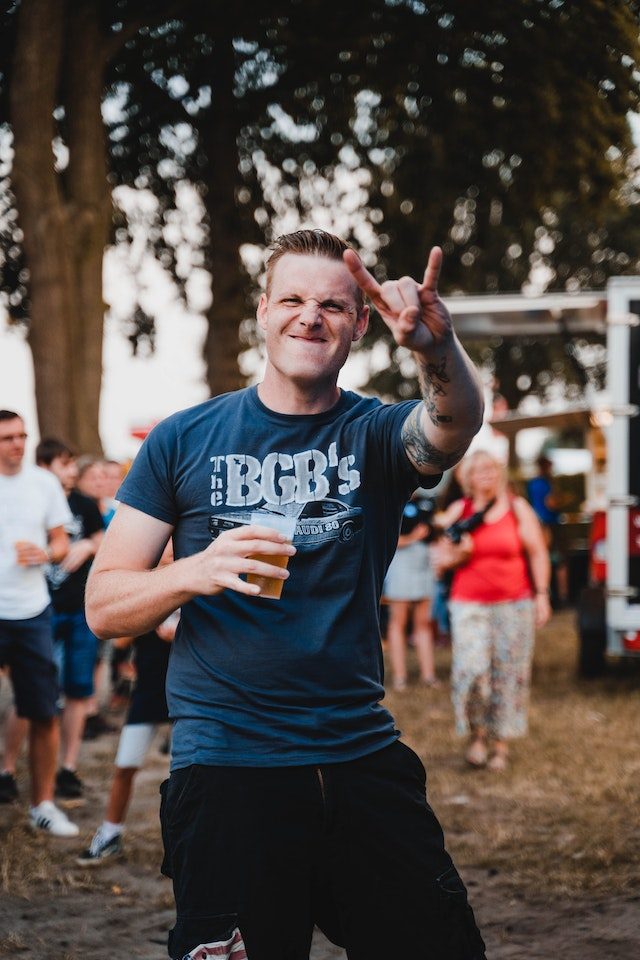

Test Image Size:,"(640, 960)"


In [19]:
test_img_name = "pexels-2769554-man-doing-rock-and-roll-sign.jpg"
test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{test_img_name}"

download_file(test_img_url, './', False)

test_img = Image.open(test_img_name)
display(test_img)

pd.Series({
    "Test Image Size:": test_img.size, 
}).to_frame().style.hide(axis='columns')

### Prepare the Test Image

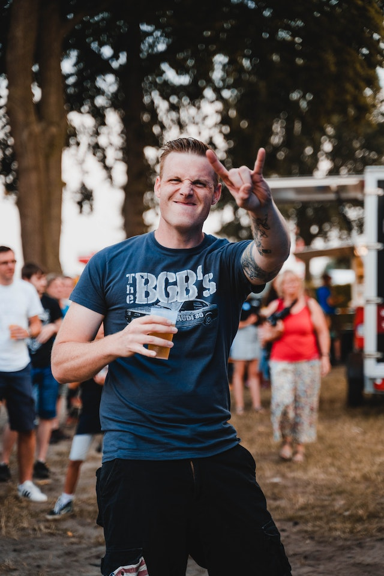

Resized Image Size:,"(384, 576)"
Input Dims:,"[384, 576]"
Offsets:,[0. 0.]
Min Image Scale:,1.666667
Input Image Size:,"(384, 576)"


In [20]:
# Set test image size
test_sz = 384

# Resize image without cropping to multiple of the max stride
resized_img = resize_img(test_img, target_sz=test_sz, divisor=1)

# Calculating the input dimensions that multiples of the max stride
input_dims = [dim - dim % max(strides) for dim in resized_img.size]

# Calculate the offsets from the resized image dimensions to the input dimensions
offsets = (np.array(resized_img.size) - input_dims)/2

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(resized_img.size)

# Crop the resized image to the input dimensions
input_img = resized_img.crop(box=[*offsets, *resized_img.size-offsets])

display(input_img)

pd.Series({
    "Resized Image Size:": resized_img.size,
    "Input Dims:": input_dims,
    "Offsets:": offsets,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

### Prepare the Input Tensor

In [21]:
# Convert the existing input image to NumPy format
input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None]/255

### Compute the Predictions

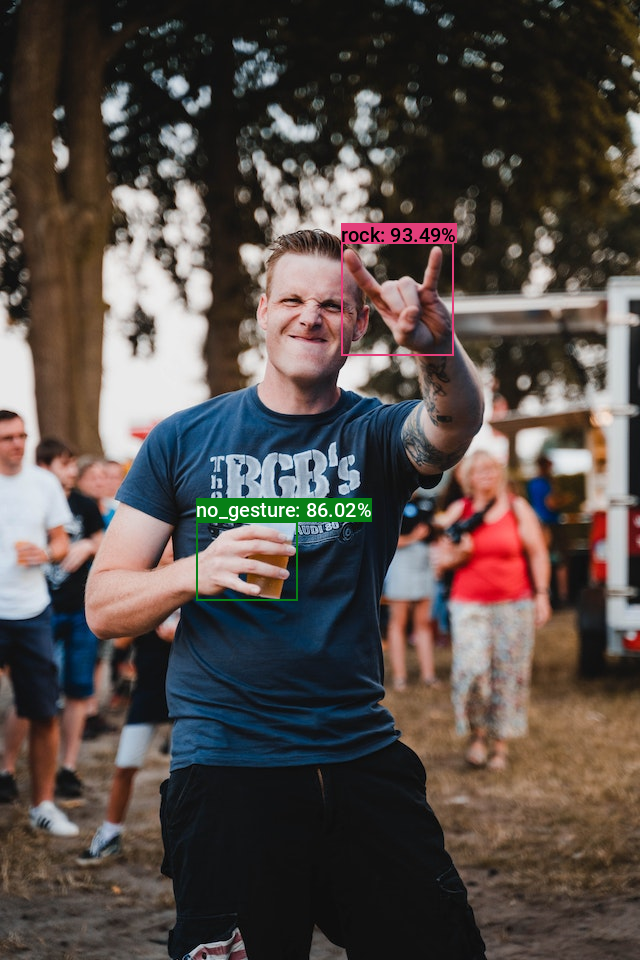

Predicted BBoxes:,"['rock:[341.796 242.258 112.071 113.383]', 'no_gesture:[196.331 521.538 100.786 78.511]']"
Confidence Scores:,"['rock: 93.49%', 'no_gesture: 86.02%']"


In [22]:
# Run inference
outputs = session.run(None, {"input": input_tensor_np})[0]

# Process the model output
if not wrapped_model.run_box_and_prob_calculation:
    outputs = calculate_boxes_and_probs(outputs, generate_output_grids_np(*input_tensor_np.shape[input_dim_slice]))

bbox_conf_thresh = 0.45
iou_thresh = 0.45

# Filter the proposals based on the confidence threshold
max_probs = outputs[:, : ,-1]
mask = max_probs > bbox_conf_thresh
proposals = outputs[mask]

# Sort the proposals by probability in descending order
proposals = proposals[proposals[..., -1].argsort()][::-1]

# Apply non-max suppression to the proposals with the specified threshold
proposal_indices = nms_sorted_boxes(calc_iou(proposals[:, :-2]), iou_thresh)
proposals = proposals[proposal_indices]

bbox_list = (proposals[:,:4]+[*offsets, 0, 0])*min_img_scale
label_list = [class_names[int(idx)] for idx in proposals[:,4]]
probs_list = proposals[:,5]

annotated_img = draw_bboxes_pil(
    image=test_img, 
    boxes=bbox_list, 
    labels=label_list,
    probs=probs_list,
    colors=[int_colors[class_names.index(i)] for i in label_list], 
    font=font_file,
)

display(annotated_img)

# Print the prediction data as a Pandas Series for easy formatting
pd.Series({
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(label_list, bbox_list.round(decimals=3))],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(label_list, probs_list)]
}).to_frame().style.hide(axis='columns')